In [1]:
import numpy as np
from cell_paint_seg.utils import get_id_to_path, check_valid_labels, threat_score, get_matches
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import io, exposure, measure
from pathlib import Path
import napari
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn. preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from PIL import Image
import os

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (co

In [2]:
def id_from_name(name):
    name_nospace = name.replace(" ", "")
    exp = name_nospace[10]
    field = name_nospace[-10:-6]
    id = f"e{exp}_{field}"
    return id

def id_from_name_mask(name):
    id = name[:7] 
    return id

In [3]:
path_tif = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/raw/"
path_gray = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/grayscale/")
path_3ch = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/")
path_release = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release")

channels = ["ER", "DNA", "Mito", "Actin", "RNA", "Golgi/membrane"]
res = 6.9e-7

id_to_path = get_id_to_path(path_tif, tag=".tif", id_from_name=id_from_name)

print(f"{len(id_to_path.keys())} samples found")


360 samples found


In [4]:
6.9e-7*1e6

0.69

# View data

In [ ]:
def id_from_name_2(name):
    name_nospace = name.replace(" ", "")
    exp = name_nospace[10]
    field = name_nospace[-21:-17]
    id = f"e{exp}_{field}"
    return id

path_fig = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/cellpaint"
id_to_path_fig = get_id_to_path(path_fig, tag="_8bit.tif", id_from_name=id_from_name_2)

id = "e1_s026"

paths = id_to_path_fig[id]
ims = read_ims(paths)
ims = [im.astype(np.float32) for im in ims]
im_rgb = np.stack([ims[3], ims[4], ims[1]], axis=-1)

im_rgb_2 = np.stack([ims[0]+ims[5], ims[4], ims[1]], axis=-1)

len(ims)

viewer = napari.Viewer()
for im in ims:  
    viewer.add_image(im, scale=[res, res])
viewer.add_image(im_rgb, rgb=True, scale=[res, res])
viewer.add_image(im_rgb_2, rgb=True, scale=[res, res])

viewer.scale_bar.visible = True
viewer.scale_bar.unit = "m"


In [ ]:
path_fig = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/prediction_examples"
id_to_path_fig = get_id_to_path(path_fig, tag=".tif", id_from_name=id_from_name)

id = "e4_s062"

paths = id_to_path_fig[id]
ims = read_ims(paths)

for path, im in zip(paths, ims):
    im_mip = np.amax(im, axis=-1)
    im_mip_clahe = exposure.equalize_adapthist(im_mip, clip_limit=0.03, kernel_size=16)
    
    path = Path(path)
    path_new = path.parent / (path.stem + "_clahe.tif")
    io.imsave(path_new, im_mip_clahe)

    im_mip_clahe_8bit = (im_mip_clahe * 255).astype(np.uint8)
    path_new = path.parent / (path.stem + "_clahe_8bit.tif")
    print(path_new)
    io.imsave(path_new, im_mip_clahe_8bit)


In [ ]:
dir = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/figures/images_e2s179/")
# get all tif files in the directory
tif_files = list(dir.glob("*.tif"))

for tif_file in tif_files:
    im = io.imread(tif_file)
    im = np.amax(im, axis=-1)
    im_clahe = exposure.equalize_adapthist(im, clip_limit=0.03, kernel_size=16)
    im_clahe_8bit = (im_clahe * 255).astype(np.uint8)
    out_path = Path(tif_file.parent) / (tif_file.stem + "_clahe_8bit.tif")
    io.imsave(out_path, im_clahe_8bit)


In [ ]:
dir = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/figures/images_e2s179/")
# get all tif files in the directory that end in 8bit.tif
tif_files = list(dir.glob("*8bit.tif"))

for tif_file in tif_files:
    print(tif_file)
    if "c4_" in tif_file.stem:
        im_r = io.imread(tif_file)
    elif "c5_" in tif_file.stem:
        im_g = io.imread(tif_file)
    elif "c2_" in tif_file.stem:
        im_b = io.imread(tif_file)


im_rgb = np.stack([im_r, im_g, im_b], axis=-1)    
out_path = Path(tif_file.parent) / "rgb.tif"
io.imsave(out_path, im_rgb)

# Random image selection/Convert

In [ ]:
im_dna = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release/images/e2_wG2_f2_c2.tif"
im_rna = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release/images/e2_wG2_f2_c4.tif"
im_actin = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release/images/e2_wG2_f2_c3.tif"
im_golgi = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release/images/e2_wG2_f2_c5.tif"

im_rgb = np.stack([io.imread(im_actin), io.imread(im_rna), io.imread(im_dna)], axis=-1)
im_rgb2 = np.stack([io.imread(im_golgi), io.imread(im_rna), io.imread(im_dna)], axis=-1)

outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/e2_s179.tif"
io.imsave(outpath, im_rgb)

outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/e2_s179_golgi.tif"
io.imsave(outpath, im_rgb2)


In [ ]:
line_names = ["ADK", "AE8", "NK3", "XH7", "ZKZ"]

for line_name in line_names:
    well = np.random.randint(1,3)
    field = np.random.randint(1,4)
    print(f"{line_name} well {well} field {field}")

ADK well 1 field 2 -> exp4, s062

AE8 well 1 field 2 -> exp 1, s026

NK3 well 1 field 3 ->  exp 3, s090

XH7 well 1 field 2 -> exp 2, s089

ZKZ well 1 field 2 -> exp 2, s178

In [ ]:
col_to_colnum = [i for i in range(2,12)] + [i for i in range(11, 1, -1)]
col_to_colnum_e1_bottom = [i for i in range(3,12)] + [i for i in range(11, 2, -1)]
assert len(col_to_colnum) == 20

for n_id, id in enumerate(id_to_path.keys()):
    for c, path in enumerate(id_to_path[id]):
        assert f"c{c+1}" in path.stem 
        
    ims = read_ims(id_to_path[id])
    ims = [np.amax(im, axis=-1) for im in ims]



    if "e1" not in id:
        loc = int(id[-3:])

        field = (loc - 1) % 3 + 1
        well = (loc - 1) // 3
        row = "BCDEFG"[well // 10]
        col = col_to_colnum[well % 20]
        
        for c, im in enumerate(ims):
            path = path_release / f"{id[:2]}_w{row}{col}_f{field}_c{c+1}.tif"
            io.imsave(path, im)
    else:
        continue
        loc = int(id[-3:])
        field = (loc - 1) % 3 + 1
        well = (loc - 1) // 3

        if loc >= 16 and loc < 118:
            row = "BCDE"[well // 10]
            col = col_to_colnum[well % 20]
        elif loc < 4:
            col = 2
            row = "E"
        elif loc >= 130 and loc < 160:
            well_reset = well - 39
            row = "FG"[well_reset // 9]
            col = col_to_colnum_e1_bottom[well_reset % 18]
        else:
            raise ValueError()


        for c, im in enumerate(ims):
            path = path_release / f"{id[:2]}_w{row}{col}_f{field}_c{c+1}.tif"
            io.imsave(path, im)


    
    if n_id == 0:
        shp = im.shape
        print(f"{im.shape} @ {im.dtype}")
    else:
        assert shp == im.shape

    # ims = [im.astype(np.float32) for im in ims]
    # im_3channel = np.stack([ims[3], ims[4], ims[1]], axis=-1)
    # im_3channel = im_3channel.astype(np.uint8)

    # io.imsave(path_3ch / f"{id}_ard.tif", im_3channel)




In [ ]:
path = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release/annotations"

# get a list of all paths of tif files in the path
path = Path(path)
paths = list(path.glob("*.tif"))
# open all files and print the data type
for path in paths:
    im = io.imread(path)
    print(f"{path} @ {im.dtype}")

# Resolve segmentations

In [ ]:
path_resolve = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_resolve = Path(path_resolve)

In [ ]:
id_to_path = get_id_to_path(path_3ch, tag=".tif", id_from_name=id_from_name_mask)
id_to_path_nuc = get_id_to_path(path_resolve, tag="nuc.", id_from_name=id_from_name_mask)
id_to_path_soma = get_id_to_path(path_resolve, tag="soma.", id_from_name=id_from_name_mask)
id_to_path_cell = get_id_to_path(path_resolve, tag="cell.", id_from_name=id_from_name_mask)

In [ ]:
ids = id_to_path_nuc.keys()
#ids = ["e2_s089"]
scale_on = False

for id in ids:
    if id != 'e2_s179':
        continue
    im = read_seg(id_to_path[id])
    mask_nuc = read_seg(id_to_path_nuc[id])
    mask_soma = read_seg(id_to_path_soma[id])
    mask_cell = read_seg(id_to_path_cell[id])


    soma_to_nuc = {}
    # compute nuc-soma matches
    for nuc_id in np.unique(mask_nuc[mask_nuc > 0]):
        nuc_area = np.sum(mask_nuc == nuc_id)
        soma_ids, overlap_areas = np.unique(mask_soma[mask_nuc == nuc_id], return_counts=True)

        for soma_id, overlap_area in zip(soma_ids, overlap_areas):
            if soma_id == 0:
                continue 

            if overlap_area/nuc_area > 0.5: # if soma is more than half of nuc, only happens once per nuc
                if soma_id in soma_to_nuc.keys(): # if soma is already assigned to a nuc
                    if overlap_area > soma_to_nuc[soma_id][1]: # soma is assigned to nuc with larger overlap area
                        soma_to_nuc[soma_id] = (nuc_id, overlap_area)
                else:
                    soma_to_nuc[soma_id] = (nuc_id, overlap_area)

                break

    cell_to_soma = {}
    # compute soma-cell matches
    for soma_id in np.unique(mask_soma[mask_soma > 0]):
        soma_area = np.sum(mask_soma == soma_id)
        mask_cell_crop = mask_cell[mask_soma == soma_id]
        cell_ids, overlap_areas = np.unique(mask_cell_crop, return_counts = True)

        for cell_id, overlap_area in zip(cell_ids, overlap_areas):
            if cell_id == 0:
                continue
            if overlap_area/soma_area > 0.5: 
                if cell_id in cell_to_soma.keys():
                    if overlap_area > cell_to_soma[cell_id][1]:
                        cell_to_soma[cell_id] = (soma_id, overlap_area)
                else:
                    cell_to_soma[cell_id] = (soma_id, overlap_area) 

                break

    triplets = []
    for cell_id in cell_to_soma.keys():
        try:
            soma_id = cell_to_soma[cell_id][0]
            nuc_id = soma_to_nuc[soma_id][0]
            triplets.append((nuc_id, soma_id, cell_id))
        except KeyError:
            continue


    print(f"{len(triplets)} matches found for {id} w/{[len(np.unique(im))-1 for im in [mask_nuc, mask_soma, mask_cell]]}")

    # combine segmentations
    mask_nuc_resolved = np.zeros_like(mask_nuc)
    mask_soma_resolved = np.zeros_like(mask_soma)
    mask_cell_resolved = np.zeros_like(mask_cell)
    for counter, match in enumerate(triplets):
        new_label = counter + 1

        mask_nuc_resolved[mask_nuc == match[0]] = new_label # establish the nucleus

        mask_soma_resolved[mask_nuc_resolved == new_label] = new_label # soma starts as the nucleus
        mask_soma_resolved[np.logical_and(mask_soma == match[1], mask_nuc == 0)] = new_label # expand soma to include pixels that aren't other nuclei

        mask_cell_resolved[mask_soma_resolved == new_label] = new_label # cell starts as the soma
        uncovered = np.logical_and(mask_soma == 0, mask_nuc == 0) #
        mask_cell_resolved[np.logical_and(mask_cell == match[2], uncovered)] = new_label # expand cell to include pixels that aren't other nuclei or somas


    check_valid_labels(mask_nuc_resolved, mask_soma_resolved, mask_cell_resolved)
    
    if scale_on:
        scale = (res,res)
    else:
        scale = None

    mask_nuc_unresolved = np.copy(mask_nuc)
    mask_soma_unresolved = np.copy(mask_soma)
    mask_cell_unresolved = np.copy(mask_cell)
    for match in triplets:
        mask_nuc_unresolved[mask_nuc_unresolved == match[0]] = 0
        mask_soma_unresolved[mask_soma_unresolved == match[1]] = 0
        mask_cell_unresolved[mask_cell_unresolved == match[2]] = 0

    viewer = napari.Viewer()
    viewer.add_image(im, name=f"{id} - 3ch", scale=scale)
    viewer.add_labels(mask_nuc_unresolved, name=f"{id} - nuc", scale=scale)
    viewer.add_labels(mask_soma_unresolved, name=f"{id} - soma", scale=scale)
    viewer.add_labels(mask_cell_unresolved, name=f"{id} - cell", scale=scale)
    viewer.scale_bar.unit = 'm'
    viewer.scale_bar.visible = True

    viewer = napari.Viewer()
    viewer.add_image(im, name=f"{id} - 3ch", scale=scale)
    viewer.add_labels(mask_nuc_resolved, name=f"{id} - nuc", scale=scale)
    viewer.add_labels(mask_soma_resolved, name=f"{id} - soma", scale=scale)
    viewer.add_labels(mask_cell_resolved, name=f"{id} - cell", scale=scale)
    viewer.scale_bar.unit = 'm'
    viewer.scale_bar.visible = True

    
    for comp, mask_resolved in zip(["nuc", "soma", "cell"], [mask_nuc_resolved, mask_soma_resolved, mask_cell_resolved]):
        path_resolved = path_resolve / f"{id}_cp_masks_{comp}_resolved.tif"
        print(path_resolved)
        io.imsave(path_resolved, mask_resolved)

        

## Double check resolved segmentations

In [ ]:
path_resolve = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_resolve = Path(path_resolve)

id_to_path = get_id_to_path(path_3ch, tag=".tif", id_from_name=id_from_name_mask)
id_to_path_nuc = get_id_to_path(path_resolve, tag="nuc_resolved.", id_from_name=id_from_name_mask)
id_to_path_soma = get_id_to_path(path_resolve, tag="soma_resolved.", id_from_name=id_from_name_mask)
id_to_path_cell = get_id_to_path(path_resolve, tag="cell_resolved.", id_from_name=id_from_name_mask)

In [ ]:
ids = id_to_path_nuc.keys()
#ids = ["e2_s089"]
scale_on = False

for id in ids:
    print(f"*******{id}*********")
    # if id != 'e3_s090':
    #     continue
    im = read_seg(id_to_path[id])
    mask_nuc = read_seg(id_to_path_nuc[id])
    mask_soma = read_seg(id_to_path_soma[id])
    mask_cell = read_seg(id_to_path_cell[id])


    check_valid_labels(mask_nuc, mask_soma, mask_cell)
    
    if scale_on:
        scale = (res,res)
    else:
        scale = None

    mask_nuc_unresolved = np.copy(mask_nuc)
    mask_soma_unresolved = np.copy(mask_soma)
    mask_cell_unresolved = np.copy(mask_cell)

    # viewer = napari.Viewer()
    # viewer.add_image(im, name=f"{id} - 3ch", scale=scale)
    # viewer.add_labels(mask_nuc_unresolved, name=f"{id} - nuc", scale=scale)
    # viewer.add_labels(mask_soma_unresolved, name=f"{id} - soma", scale=scale)
    # viewer.add_labels(mask_cell_unresolved, name=f"{id} - cell", scale=scale)
    # viewer.scale_bar.unit = 'm'
    # viewer.scale_bar.visible = True


        

## Count annotations

In [ ]:
dir_annot = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/release/annotations")

# get a list of all paths of tif files in the path
paths = list(dir_annot.glob("*.tif"))
paths = [path for path in paths if "_ann1" in path.stem]

tag = "cell"

paths = [path for path in paths if tag in path.stem]
paths

total = 0
for path in paths:
    seg = io.imread(path)
    unq = np.unique(seg)
    assert 0 in unq
    total += len(unq) - 1

print(total)


# Inter-annotator reliability

In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alba = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"


ann_to_path = {"Ann. 1": path_tommy, "Ann. 2": path_aneesh, "Ann. 3": path_alba}

tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}

data_count = []
data_annotator = []
data_compartment = []
data_id = []


for ann1 in tqdm(ann_to_path.keys(), desc="annotators..."):
    path_ann_1 = ann_to_path[ann1]



    for compartment in tqdm(["nuc", "soma", "cell"], leave=False, desc="compartments..."):
        id_to_paths_ann1 = get_id_to_path(path_ann_1, id_from_name_mask, tag=f"_{compartment}_resolved")

        for id, path in tqdm(id_to_paths_ann1.items(), leave=False, desc="ids..."):
            seg_ann1 = read_seg(path)

            data_count.append(len(np.unique(seg_ann1))-1)
            data_annotator.append(ann1)
            data_compartment.append(tag_to_name[compartment])
            data_id.append(id)

df = pd.DataFrame({"Count": data_count, "Annotator": data_annotator, "Compartment": data_compartment, "ID": data_id})
# sort by annotator then by ID
df = df.sort_values(by=["Annotator", "ID"])

df[(df["Annotator"] == "Ann. 1") & (df["Compartment"] == "Nuclei")]

In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alba = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"


ann_to_path = {"Ann. 1": path_tommy, "Ann. 2": path_aneesh, "Ann. 3": path_alba}

tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}


data_val = []
data_metric = []
data_iou = []
data_comp = []
data_pair = []
data_id = []

data_semantic_iou = []
data_semantic_comp = []
data_semantic_pair = []


for ann1, ann2 in tqdm([("Ann. 1", "Ann. 2"), ("Ann. 1", "Ann. 3"), ("Ann. 2", "Ann. 3")], desc="annotator pairs..."):
    path_ann_1 = ann_to_path[ann1]
    path_ann_2 = ann_to_path[ann2]
    for compartment in tqdm(["nuc", "soma", "cell"], leave=False, desc="compartments..."):
        id_to_paths_ann1 = get_id_to_path(path_ann_1, id_from_name_mask, tag=f"_{compartment}_resolved")
        id_to_paths_ann2 = get_id_to_path(path_ann_2, id_from_name_mask, tag=f"_{compartment}_resolved")

        for id, path in tqdm(id_to_paths_ann2.items(), leave=False, desc="ids..."):
            seg_ann2 = read_seg(path)
            seg_ann1 = read_seg(id_to_paths_ann1[id])

            seg_binary1 = seg_ann1 > 0
            seg_binary2 = seg_ann2 > 0
            semantic_iou = np.sum(np.logical_and(seg_binary1, seg_binary2)) / np.sum(np.logical_or(seg_binary1, seg_binary2))
            data_semantic_iou.append(semantic_iou)
            data_semantic_comp.append(tag_to_name[compartment])
            data_semantic_pair.append(f"{ann1} vs {ann2}")

            for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
                tps, fps, fns = threat_score(seg_ann1, seg_ann2, iou_thresh)
                prec = tps / (tps + fps)
                rec = tps / (tps + fns)
                threat = tps / (tps + fps + fns)
                f1 = 2 * prec * rec / (prec + rec)
                for metric, val in zip(["F1 Score"], [f1]):
                    data_iou.append(iou_thresh)
                    data_metric.append(metric)
                    data_val.append(val)
                    data_comp.append(tag_to_name[compartment])
                    data_pair.append(f"{ann1} vs {ann2}")
                    data_id.append(id)

df = pd.DataFrame({"IoU Threshold": data_iou, "F1 Score": data_val, "Metric": data_metric, "Compartment": data_comp, "Comparison": data_pair, "ID": data_id})
df_semantic = pd.DataFrame({"Semantic IoU": data_semantic_iou, "Compartment": data_semantic_comp, "Comparison": data_semantic_pair})

In [ ]:
f, axs = plt.subplots(1, 4, figsize=(24, 6))

for compartment, ax in zip(["Nuclei", "Somas", "Cells"], axs):
    sns.lineplot(data=df[df["Compartment"] == compartment ], x="IoU Threshold", y="F1 Score", hue="Comparison", ax=ax, errorbar="sd")
    ax.set_title(compartment)
    ax.set_ylim(0, 1.0)


sns.stripplot(data=df_semantic, x="Compartment", y="Semantic IoU", hue="Comparison", ax=axs[-1])
plt.ylim(0, 1.0)


axs[0].set_title("a) Nuclei Instance Agreement")
axs[1].set_title("b) Somas Instance Agreement")
axs[2].set_title("c) Cell Instance Agreement")
axs[3].set_title("d) Semantic Agreement")

for ax in axs:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)

    for item in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts()):
        item.set_fontsize(12)


# move the legend of the last plot to the bottom right
axs[-1].legend(loc='lower right')

#plt.suptitle("Tommy vs Aneesh Agreement")
#plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/figures/aggreement_1.svg")

## View different annotations

In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alba = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"

id = "e1_s026"
scale_on = False 

if scale_on:
    scale = (res,res)
else:
    scale = None


id_to_path_im = get_id_to_path(path_im, id_from_name_mask, tag=f".tif")
im = read_seg(id_to_path_im[id])
im = im[:200,:200]


viewer = napari.Viewer()
viewer.add_image(im, rgb=True, scale=scale)

for path_ann, name in zip([path_tommy, path_aneesh, path_alba], ["Tommy", "Aneesh", "Alba"]):
    id_to_paths_ann = get_id_to_path(path_ann, id_from_name_mask, tag=f"_resolved")

    segs = read_ims(id_to_paths_ann[id])
    segs = [seg[:200,:200] for seg in segs]
    for seg, compartment in zip(segs, ["cell", "nuc", "soma"]):
        viewer.add_labels(seg, name=f"{name}-{compartment}", scale=scale)

viewer.scale_bar.unit = 'm'
viewer.scale_bar.visible = True


In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alba = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"

id = "e1_s026"
scale_on = True 

if scale_on:
    scale = (res,res)
else:
    scale = None


id_to_path_im = get_id_to_path(path_im, id_from_name_mask, tag=f".tif")
im = read_seg(id_to_path_im[id])
im = im[:200,:200]


viewer = napari.Viewer()
viewer.add_image(im, rgb=True, scale=scale)
# perform clahe
im = exposure.equalize_adapthist(im, clip_limit=0.03, kernel_size=16)
im = (im*255).astype(np.uint8)
outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/agreement_viz/im_rgb.tif"
io.imsave(outpath, im)


id_to_paths_1 = get_id_to_path(path_tommy, id_from_name_mask, tag=f"_resolved")
id_to_paths_2 = get_id_to_path(path_alba, id_from_name_mask, tag=f"_resolved")

segs1 = read_ims(id_to_paths_1[id])
segs2 = read_ims(id_to_paths_2[id])

segs1 = [seg[:200,:200] for seg in segs1]
segs2 = [seg[:200,:200] for seg in segs2]

seg1 = segs1[0]
seg2 = segs2[0]

matches = get_matches(seg1, seg2)
tps, fps, fns = threat_score(seg1, seg2, 0.5)
f1 = 2 * tps / (2 * tps + fps + fns)
print(f"F1: {f1}")

seg1_resolved = np.zeros_like(seg1)
for match in matches:
    seg1_resolved[seg1 == match[0]] = match[1]

seg1_unresolved = np.copy(seg1)
for match in matches:
    seg1_unresolved[seg1_unresolved == match[0]] = 0

seg2_resolved = np.zeros_like(seg2)
for match in matches:
    seg2_resolved[seg2 == match[1]] = match[0]

seg2_unresolved = np.copy(seg2)
for match in matches:
    seg2_unresolved[seg2_unresolved == match[1]] = 0

# use the pyplot winter colormap in viewer add_labels
viewer.add_labels(seg1, name="Tommy - complete", scale=scale)
viewer.add_labels(seg2, name="Alba - complete", scale=scale)

cell_semantic = (seg1 > 0).astype(int) + (seg2 > 0).astype(int)
cell_semantic_viz = np.zeros((seg1.shape[0], seg1.shape[1], 3), dtype=int)
cell_semantic_viz[cell_semantic == 0, :] = (0,0,0)
cell_semantic_viz[cell_semantic == 1, :] = (1,0,0)
cell_semantic_viz[cell_semantic == 2, :] = (0,1,0)
# color_mapping = {0: (0,0,0,0), 1: (1,0,0,1), 2: (0,1,0,1)}
# color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
viewer.add_image(cell_semantic_viz, name="Semantic", scale=scale, rgb=True)
cell_semantic_viz = (cell_semantic_viz*255).astype(np.uint8)
outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/agreement_viz/semantic.tif"
io.imsave(outpath, cell_semantic_viz)
iou = np.sum(np.logical_and(seg1 > 0, seg2 > 0)) / np.sum(np.logical_or(seg1 > 0, seg2 > 0))
print(f"Semantic IoU: {iou}")


cmap = plt.cm.Greens
norm = plt.Normalize(0, len(np.unique(seg1_resolved)))
seg1_viz = np.zeros((seg1_resolved.shape[0], seg1_resolved.shape[1], 3), dtype=float)
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg1_resolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg1_resolved):
    seg1_viz[seg1_resolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg1_resolved, name="Tommy - resolved", scale=scale, colormap=color_mapping)


cmap = plt.cm.Reds
norm = plt.Normalize(0, len(np.unique(seg1_unresolved)))
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg1_unresolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg1_unresolved):
    if lbl == 0:
        continue
    seg1_viz[seg1_unresolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg1_unresolved, name="Tommy - unresolved", scale=scale, colormap=color_mapping)
viewer.add_image(seg1_viz, name="Tommy - instance", scale=scale, rgb=True)
seg1_viz = (seg1_viz*255).astype(np.uint8)
outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/agreement_viz/tommy_cell.tif"
io.imsave(outpath, seg1_viz)


cmap = plt.cm.Greens
norm = plt.Normalize(0, len(np.unique(seg2_resolved)))
seg2_viz = np.zeros((seg2_resolved.shape[0], seg2_resolved.shape[1], 3), dtype=float)
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg2_resolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg2_resolved):
    seg2_viz[seg2_resolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg2_resolved, name="Alba - resolved", scale=scale, colormap=color_mapping)


cmap = plt.cm.Reds
norm = plt.Normalize(0, len(np.unique(seg2_unresolved)))
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg2_unresolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg2_unresolved):
    if lbl == 0:
        continue
    seg2_viz[seg2_unresolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg2_unresolved, name="Alba - unresolved", scale=scale, colormap=color_mapping)
viewer.add_image(seg2_viz, name="Alba - instance", scale=scale, rgb=True) 
seg2_viz = (seg2_viz*255).astype(np.uint8)
outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/agreement_viz/alba_cell.tif"
io.imsave(outpath, seg2_viz)


# Nuclei

seg1 = segs1[1]
seg2 = segs2[1]

matches = get_matches(seg1, seg2)
tps, fps, fns = threat_score(seg1, seg2, 0.5)
f1 = 2 * tps / (2 * tps + fps + fns)
print(f"F1: {f1}")

seg1_resolved = np.zeros_like(seg1)
for match in matches:
    seg1_resolved[seg1 == match[0]] = match[1]

seg1_unresolved = np.copy(seg1)
for match in matches:
    seg1_unresolved[seg1_unresolved == match[0]] = 0

seg2_resolved = np.zeros_like(seg2)
for match in matches:
    seg2_resolved[seg2 == match[1]] = match[0]

seg2_unresolved = np.copy(seg2)
for match in matches:
    seg2_unresolved[seg2_unresolved == match[1]] = 0

# use the pyplot winter colormap in viewer add_labels
viewer.add_labels(seg1, name="Tommy - complete", scale=scale)
viewer.add_labels(seg2, name="Alba - complete", scale=scale)


cmap = plt.cm.Greens
norm = plt.Normalize(0, len(np.unique(seg1_resolved)))
seg1_viz = np.zeros((seg1_resolved.shape[0], seg1_resolved.shape[1], 3), dtype=float)
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg1_resolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg1_resolved):
    seg1_viz[seg1_resolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg1_resolved, name="Tommy - resolved", scale=scale, colormap=color_mapping)


cmap = plt.cm.Reds
norm = plt.Normalize(0, len(np.unique(seg1_unresolved)))
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg1_unresolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg1_unresolved):
    if lbl == 0:
        continue
    seg1_viz[seg1_unresolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg1_unresolved, name="Tommy - unresolved", scale=scale, colormap=color_mapping)
viewer.add_image(seg1_viz, name="Tommy - instance", scale=scale, rgb=True)
seg1_viz = (seg1_viz*255).astype(np.uint8)
outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/agreement_viz/tommy_nuc.tif"
io.imsave(outpath, seg1_viz)

cmap = plt.cm.Greens
norm = plt.Normalize(0, len(np.unique(seg2_resolved)))
seg2_viz = np.zeros((seg2_resolved.shape[0], seg2_resolved.shape[1], 3), dtype=float)
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg2_resolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg2_resolved):
    seg2_viz[seg2_resolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg2_resolved, name="Alba - resolved", scale=scale, colormap=color_mapping)


cmap = plt.cm.Reds
norm = plt.Normalize(0, len(np.unique(seg2_unresolved)))
color_mapping = {lbl: cmap(norm(i)) for i, lbl in enumerate(np.unique(seg2_unresolved))}
color_mapping[0] = (0,0,0,0)
for lbl in np.unique(seg2_unresolved):
    if lbl == 0:
        continue
    seg2_viz[seg2_unresolved == lbl, :] = color_mapping[lbl][:3]
color_mapping = napari.utils.DirectLabelColormap(color_dict=color_mapping)
#viewer.add_labels(seg2_unresolved, name="Alba - unresolved", scale=scale, colormap=color_mapping)
viewer.add_image(seg2_viz, name="Alba - instance", scale=scale, rgb=True)
seg2_viz = (seg2_viz*255).astype(np.uint8)
outpath = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/agreement_viz/alba_nuc.tif"
io.imsave(outpath, seg2_viz)

# viewer.add_labels(seg1, name="Tommy", scale=scale)
# viewer.add_labels(seg2_resolved, name="Alba", scale=scale)

#viewer.theme = 'light'
viewer.scale_bar.unit = 'm'
viewer.scale_bar.visible = True


# Evaluate algorithms

- cellpose - done
- omnipose - done
- cellprofiler (otsu) - done
- https://github.com/selimsef/dsb2018_topcoders/ - #1 kaggle for nuclei # old cuda version


In [5]:
def unq_lbl(seg):
    # convert rgb to grayscale
    if seg.ndim == 3:
        seg_new = np.zeros(seg.shape[:2], dtype=np.uint32)
        seg_new = seg[:,:,0]*256**2 + seg[:,:,1]*256 + seg[:,:,2]
        seg = seg_new

    # separate connected components
    seg_new = np.zeros_like(seg)
    counter = 1
    for lbl in np.unique(seg[seg > 0]):
        label = measure.label(seg == lbl)
        for new_lbl in np.unique(label):
            if new_lbl == 0:
                continue
            seg_new[label == new_lbl] = counter
            counter += 1
    return seg_new


In [7]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alg = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto3"
path_cellpose_train = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cellpose_train"
path_cellpose_trainval = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cellpose_trainval"
path_omni = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto2_omni"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"
path_cellprof = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/grayscale/cellprofiler/"
path_sam = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/SAM"
path_mediar = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/mediar"
path_mediar_trainval = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/mediar_train"
path_star = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/stardist"
path_hover = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/hover/cpm"
path_cellvit = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cellvit"

paths = {"Ann. 1": path_tommy, "Ann. 2": path_aneesh, "Cellpose Cyto3": path_alg,
         "Omnipose Cyto2": path_omni, "CellProfiler": path_cellprof, "SAM": path_sam,
         "Mediar": path_mediar, "Hover - CPM": path_hover, "StarDist": path_star,
         "CellViT": path_cellvit, "Cellpose Cyto3:Finetune": path_cellpose_train,
         "Cellpose - Finetune, Val": path_cellpose_trainval, "Mediar:Finetune": path_mediar_trainval}

pairs = [("Ann. 1", "Ann. 2"), ("Ann. 1", "Cellpose Cyto3"), ("Ann. 1", "Cellpose Cyto3:Finetune"),
         ("Ann. 1", "StarDist"), ("Ann. 1", "Mediar"),  ("Ann. 1", "Mediar:Finetune"),
         ("Ann. 1", "CellViT"), ("Ann. 1", "Omnipose Cyto2"), ("Ann. 1", "CellProfiler"),
         ("Ann. 1", "Hover - CPM"), ("Ann. 1", "SAM")]

#pairs = [("Ann. 1", "Mediar"),  ("Ann. 1", "Mediar - Finetune")]


tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}

data_val = []
data_metric = []
data_iou = []
data_comp = []
data_method = []
data_finetune = []

data_semantic_iou = []
data_semantic_comp = []
data_semantic_matchup = []

ann_to_copy = {}

for ann in tqdm(paths.keys(), desc="annotator pairs..."):
    path_ann = paths[ann]
    id_to_soma = {}
    for compartment in ["soma", "cell"]:
        if ann in ann_to_copy.keys():
                continue
        if ann == "Ann. 2":
            tag = f"_{compartment}_resolved"
        elif compartment == "cell" and (ann == "Cellpose Cyto3" or ann == "SAM"):
            tag = "_cell-s"
        # elif compartment == "cell" and ann == "SAM":
        #     tag = "_cell-a"
        else:
            tag = f"_{compartment}."
        id_to_paths_ann = get_id_to_path(path_ann, id_from_name_mask, tag=tag)


        for id, path in tqdm(id_to_paths_ann.items(), leave=False, desc="ids..."):
            if ann in ann_to_copy.keys():
                    continue
            seg = read_seg(path)

            if ann == "Omnipose Cyto2" or ann == "CellProfiler":
                seg_2 = unq_lbl(seg)
            
            if id not in id_to_soma.keys():
                id_to_soma[id] = seg
            else:
                if np.all(seg == id_to_soma[id]):
                    ann_to_copy[ann] = True
                else:
                    ann_to_copy[ann] = False

print(ann_to_copy)



annotator pairs...:   0%|          | 0/13 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/2 [00:00<?, ?it/s]

ids...: 0it [00:00, ?it/s]

ids...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/3 [00:00<?, ?it/s]

{'Ann. 1': False, 'Ann. 2': False, 'Cellpose Cyto3': True, 'Omnipose Cyto2': True, 'CellProfiler': False, 'SAM': True, 'Mediar': True, 'Hover - CPM': True, 'StarDist': True, 'CellViT': True, 'Cellpose Cyto3:Finetune': False, 'Mediar:Finetune': False}


In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alg = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto3"
path_cellpose_train = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cellpose_train"
path_cellpose_trainval = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cellpose_trainval"
path_omni = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto2_omni"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"
path_cellprof = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/grayscale/cellprofiler/"
path_sam = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/SAM"
path_mediar = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/mediar"
path_mediar_trainval = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/mediar_train"
path_star = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/stardist"
path_hover = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/hover/cpm"
path_cellvit = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cellvit"

paths = {"Ann. 1": path_tommy, "Ann. 2": path_aneesh, "Cellpose Cyto3": path_alg,
         "Omnipose Cyto2": path_omni, "CellProfiler": path_cellprof, "SAM": path_sam,
         "Mediar": path_mediar, "Hover - CPM": path_hover, "StarDist": path_star,
         "CellViT": path_cellvit, "Cellpose Cyto3:Finetune": path_cellpose_train,
         "Cellpose - Finetune, Val": path_cellpose_trainval, "Mediar:Finetune": path_mediar_trainval}

pairs = [("Ann. 1", "Ann. 2"), ("Ann. 1", "Cellpose Cyto3"), ("Ann. 1", "Cellpose Cyto3:Finetune"),
         ("Ann. 1", "StarDist"), ("Ann. 1", "Mediar"),  ("Ann. 1", "Mediar:Finetune"),
         ("Ann. 1", "CellViT"), ("Ann. 1", "Omnipose Cyto2"), ("Ann. 1", "CellProfiler"),
         ("Ann. 1", "Hover - CPM"), ("Ann. 1", "SAM")]

#pairs = [("Ann. 1", "Mediar"),  ("Ann. 1", "Mediar - Finetune")]


tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}

data_val = []
data_metric = []
data_iou = []
data_comp = []
data_method = []
data_finetune = []

data_semantic_iou = []
data_semantic_comp = []
data_semantic_matchup = []

for ann1, ann2 in tqdm(pairs, desc="annotator pairs..."):
    path_ann1 = paths[ann1]
    path_ann2 = paths[ann2]
    for compartment in tqdm(list(tag_to_name.keys()), leave=False, desc="compartments..."):
        id_to_paths_ann1 = get_id_to_path(path_ann1, id_from_name_mask, tag=f"_{compartment}_resolved")
        if ann2 == "Ann. 2":
            tag_2 = f"_{compartment}_resolved"
        elif compartment == "cell" and (ann2 == "Cellpose Cyto3" or ann2 == "SAM"):
            tag_2 = "_cell-s"
        # elif compartment == "cell" and ann2 == "SAM":
        #     tag_2 = "_cell-a"
        else:
            tag_2 = f"_{compartment}."
        id_to_paths_ann2 = get_id_to_path(path_ann2, id_from_name_mask, tag=tag_2)

        for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
            tp_total = 0
            fp_total = 0
            fn_total = 0
            for id, path in tqdm(id_to_paths_ann1.items(), leave=False, desc="ids..."):
                if id == 'e1_s026' or id == 'e4_s062' or id == "e2_s179":
                    pass
                else:
                    continue
                
                try:
                    seg_1 = read_seg(path)
                    seg_2 = read_seg(id_to_paths_ann2[id])
                    if ann2 == "Omnipose Cyto2" or ann2 == "CellProfiler":
                        seg_2 = unq_lbl(seg_2)
                    
                    tps, fps, fns = threat_score(seg_1, seg_2, iou_thresh)
                    tp_total += tps
                    fp_total += fps
                    fn_total += fns
                except Exception as e:
                    print(f"Exception: {e} under {ann1} vs {ann2}, {compartment}")
                    pass

            # if "Cyto3" in ann2:
            #     metrics, vals = ["Threat Score", "Precision", "Recall"], [tp_total/(tp_total+fp_total+fn_total), tp_total/(tp_total + fp_total), tp_total/(tp_total + fn_total)]
            # else:
            #     metrics, vals = ["Threat Score"], [tp_total/(tp_total+fp_total+fn_total)]

            if tp_total + fp_total == 0:
                prec = 1
            else:
                prec = tp_total / (tp_total + fp_total)
            rec = tp_total / (tp_total + fn_total)

            if prec + rec == 0:
                f1 = 0
            else:
                f1 = 2 * (prec * rec) / (prec + rec)
            metrics, vals = ["F1 Score"], [f1]

            for metric, val in zip(metrics, vals):
                data_iou.append(iou_thresh)
                data_metric.append(metric)
                data_val.append(val)
                data_comp.append(tag_to_name[compartment])
                data_method.append(ann2.split(':')[0])
                if len(ann2.split(":")) > 1:
                    data_finetune.append(True)
                else:
                    data_finetune.append(False)

df = pd.DataFrame({"IoU Threshold": data_iou, "F1 Score": data_val, "Metric": data_metric, "Compartment": data_comp, "Comparison": data_method, "Finetuned": data_finetune})


In [ ]:
df_full = df

In [ ]:
df = df_full[df_full["Finetuned"] == False]

f, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for compartment, ax in zip(["Nuclei", "Somas", "Cells"], axs):
    sns.lineplot(data=df[df["Compartment"] == compartment], ax=ax, x="IoU Threshold", y="F1 Score", hue="Comparison")#, style="Finetuned")
    ax.set_title(compartment)

# axs[0].set_title("Nuclei Instance Agreement")
# axs[1].set_title("b) Somas Instance Agreement")
# axs[2].set_title("c) Cell Instance Agreement")


for ax in axs:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)

    for item in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts()):
        item.set_fontsize(12)

# remove legend except for last panel
for ax in axs[:-1]:
    ax.get_legend().remove()
    
plt.ylim(0, 1.0)
#plt.suptitle("Cellpose Cyto3 Performance")
plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/figures/alg_results/performance.svg")

## Mediar

In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alg = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto3"
path_omni = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto2_omni"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"
path_cellprof = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/grayscale/cellprofiler/"
path_sam = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/SAM"
path_mediar = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/mediar"

paths = {"Ann. 1": path_tommy, "Ann. 2": path_aneesh, "Cellpose Cyto3": path_alg, "Omnipose Cyto2": path_omni, "CellProfiler": path_cellprof, "SAM": path_sam, "Mediar": path_mediar}

tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}


data_val = []
data_metric = []
data_iou = []
data_comp = []
data_matchup = []

data_semantic_iou = []
data_semantic_comp = []
data_semantic_matchup = []

for ann1, ann2 in tqdm([("Ann. 1", "Ann. 2"), ("Ann. 1", "Mediar")], desc="annotator pairs..."):
    path_ann1 = paths[ann1]
    path_ann2 = paths[ann2]
    for compartment in tqdm(["nuc"], leave=False, desc="compartments..."):
        id_to_paths_ann1 = get_id_to_path(path_ann1, id_from_name_mask, tag=f"_{compartment}_resolved")
        if ann2 == "Ann. 2":
            tag_2 = f"_{compartment}_resolved"
        elif compartment == "cell" and ann2 == "Cellpose Cyto3":#(ann2 == "Cellpose Cyto3" or ann2 == "SAM"):
            tag_2 = "_cell-s"
        elif compartment == "cell" and ann2 == "SAM":
            tag_2 = "_cell-a"
        else:
            tag_2 = f"_{compartment}"
        id_to_paths_ann2 = get_id_to_path(path_ann2, id_from_name_mask, tag=tag_2)

        for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
            tp_total = 0
            fp_total = 0
            fn_total = 0
            for id, path in tqdm(id_to_paths_ann1.items(), leave=False, desc="ids..."):
                if id == 'e1_s026' or id == 'e4_s062':
                    pass
                else:
                    continue
                
                try:
                    seg_1 = read_seg(path)
                    seg_2 = read_seg(id_to_paths_ann2[id])
                    if ann2 == "Omnipose Cyto2" or ann2 == "CellProfiler":
                        seg_2 = unq_lbl(seg_2)
                    
                    tps, fps, fns = threat_score(seg_1, seg_2, iou_thresh)
                    tp_total += tps
                    fp_total += fps
                    fn_total += fns
                except Exception as e:
                    print(f"Exception: {e}")
                    pass

            # if "Cyto3" in ann2:
            #     metrics, vals = ["Threat Score", "Precision", "Recall"], [tp_total/(tp_total+fp_total+fn_total), tp_total/(tp_total + fp_total), tp_total/(tp_total + fn_total)]
            # else:
            #     metrics, vals = ["Threat Score"], [tp_total/(tp_total+fp_total+fn_total)]

            prec = tp_total / (tp_total + fp_total)
            rec = tp_total / (tp_total + fn_total)
            if prec + rec == 0:
                f1 = 0
            else:
                f1 = 2 * (prec * rec) / (prec + rec)
            metrics, vals = ["F1 Score"], [f1]

            for metric, val in zip(metrics, vals):
                data_iou.append(iou_thresh)
                data_metric.append(metric)
                data_val.append(val)
                data_comp.append(tag_to_name[compartment])
                data_matchup.append(f"{ann1} vs {ann2}")

df = pd.DataFrame({"IoU Threshold": data_iou, "F1 Score": data_val, "Metric": data_metric, "Compartment": data_comp, "Comparison": data_matchup})


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(18, 6), sharey=True)

sns.lineplot(data=df[df["Compartment"] == "Nuclei"], x="IoU Threshold", y="F1 Score", hue="Comparison", ax=ax)
ax.set_title(compartment)

# axs[0].set_title("Nuclei Instance Agreement")
# axs[1].set_title("b) Somas Instance Agreement")
# axs[2].set_title("c) Cell Instance Agreement")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(18)

# for item in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts()):
#     item.set_fontsize(12)

plt.ylim(0, 1.0)
#plt.suptitle("Cellpose Cyto3 Performance")

## View segmentations

In [ ]:
im = io.imread("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/prediction_examples/e4_s062.tif")
im_rna = im[:,:,1]
io.imsave("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/prediction_examples/e4_s062_rna.tif", im_rna)


# All plates

## Formatting

In [ ]:
raw_dir = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/raw"

# get all tif files from raw directory
raw_paths = list(Path(raw_dir).rglob("*.tif"))
stems = [raw_path.stem.replace(" ", "") for raw_path in raw_paths]
es = [f"e{stem[10]}" for stem in stems]
ss = [f"s{stem.split('_')[-1].split('c')[0][1:].zfill(3)}" for stem in stems]
cs = [f"c{stem[-1]}" for stem in stems]

es_int = [int(e[1:]) for e in es]
ss_int = [int(s[1:]) for s in ss]
cs_int = [int(c[1:]) for c in cs]

data = {"e": es, "s": ss, "c": cs, "e_int": es_int, "s_int": ss_int, "c_int": cs_int, "path": raw_paths}
df = pd.DataFrame(data)

for e in tqdm(df["e"].unique()):
    for s in tqdm(df[df["e"] == e]["s"].unique(), leave=False):
        df_sample = df[df["e"] == e][df["s"] == s]
        im = None
        # sort the rows of df_sample by c_int
        df_sample = df_sample.sort_values(by="c_int")
        paths = [df_sample[df_sample["c_int"] == c]["path"].values[0] for c in [4,5,2]]
        ims = [io.imread(path) for path in paths]
        ims = [np.amax(im, axis=-1) for im in ims]
        im_rgb = np.stack(ims, axis=-1)

        #io.imsave(Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/ARD") / f"{e}_{s}_ARD.tif", im_rgb)
        

### Add well ID field

In [ ]:
path = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/ARD_2"
ext = "tif"

# get a list of all paths of tif files in the path
path = Path(path)
paths = list(path.glob(f"*.{ext}"))

# change each file name to hi.tif
for path in paths:
    loc = int(path.stem.split("_")[1][1:])
    well_id = (loc - 1) // 3 + 1
    well_id = str(well_id).zfill(3)
    path.rename(path.with_name(path.stem[:7] + f"_w{well_id}" + f"{path.stem[7:]}.{ext}"))


## Apply cellpose

`python -m cellpose --dir /Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/ARD --pretrained_model cyto3 --chan 2 --chan2 3 --save_png --diameter 0. --verbose`

## Analyze control dataset

In [17]:
def field_to_line(field, exp):
    if exp == 1 and field < 4:
        return "ZKZiCTR" 

    if exp == 1:
        if field < 61:
            return "AE8iCTR"
        elif field >= 61 and field < 121:
            return "ZKZiCTR"
        else:
            return "XH7iCTR"
    elif exp == 2:
        if field < 61:
            return "AE8iCTR"
        elif field >= 61 and field < 121:
            return "XH7iCTR"
        else:
            return "ZKZiCTR"
    elif exp == 3:
        if field < 61:
            return "ADKiCTR"
        elif field >= 61 and field < 121:
            return "NK3iCTR"
        else:
            return "ZKZiCTR"
    elif exp == 4:
        if field < 61:
            return "XH7iCTR"
        elif field >= 61 and field < 121:
            return "ADKiCTR"
        else:
            return "AE8iCTR"
        
def field_to_condition(field, exp):
    if exp == 1:
        if ((field >= 16 and field < 22) or 
            (field >= 70 and field < 76) or (field >= 91 and field < 97) or 
            (field >=136 and field < 139) or (field >= 151 and field < 154)):
            return "KPT"
        elif ((field >= 7 and field < 13) or (field > 40 and field < 46) or
            (field >= 64 and field < 70) or (field >= 76 and field < 82) or
            (field >= 130 and field < 136)):
            return "H2O2"
        elif ((field >= 55 and field < 61) or (field >= 31 and field < 37) or
              (field < 4) or (field >= 115 and field < 118) or (field >= 82 and field < 88) or
              (field >= 139 and field < 145) or (field >= 127 and field < 130) or (field >= 160 and field < 163)):
            return "Tunicamysin"
        elif ((field >= 49 and field < 55) or (field >= 22 and field < 25) or (field >= 37 and field < 40) or 
              (field >= 97 and field < 103) or (field >= 109 and field < 115) or 
              (field >= 145 and field < 151)):
            return "Autophagy"
        else:
            return "DMSO"

    else:
        if (field < 7 or (field >= 16 and field < 22) or 
            (field >= 70 and field < 76) or (field >= 91 and field < 97) or 
            (field >=127 and field < 133) or (field >= 142 and field < 145) or (field >= 157 and field < 160)):
            return "KPT"
        elif ((field >= 7 and field < 13) or (field > 40 and field < 46) or
            (field >= 64 and field < 70) or (field >= 76 and field < 82) or
            (field >= 136 and field < 142) or (field >= 169 and field < 175)):
            return "H2O2"
        elif ((field >= 55 and field < 61) or (field >= 31 and field < 37) or
              (field >= 82 and field < 88) or (field >= 115 and field < 121) or
              (field >= 145 and field < 151) or (field >= 133 and field < 136) or (field >= 166 and field < 169)):
            return "Tunicamysin"
        elif ((field >= 49 and field < 55) or (field >= 22 and field < 25) or (field >= 37 and field < 40) or 
              (field >= 97 and field < 103) or (field >= 109 and field < 115) or 
              (field >= 121 and field < 127) or (field >= 151 and field < 157)):
            return "Autophagy"
        else:
            return "DMSO"
    

In [18]:
def id_from_name_all_control(name):
    id = name[:7]
    return id

id_to_path_seg = get_id_to_path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/ARD", id_from_name_all_control, tag="_masks")
id_to_path_im = get_id_to_path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/ARD", id_from_name_all_control, tag="ARD.tif")
print(f"{len(id_to_path_seg.keys())} samples found out of {len(id_to_path_im.keys())}")

360 samples found out of 360


In [19]:
data_task = []
data_acc = []
data_null_acc = []
data_pval = []

df = pd.read_csv("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/SomaRNA_Image.csv")
cols_X = [c for c in df.columns if "Mean" in c or "Count" in c]
cols_X = [c for c in cols_X if "_X" not in c]
cols_X = [c for c in cols_X if "_Y" not in c]
cols_X = [c for c in cols_X if "_Z" not in c]
cols_X = [c for c in cols_X if "Actin" not in c]
cols_Y = [c for c in df.columns if c == "Metadata_Field" or c == "Metadata_Plate"]

df = df[cols_X + cols_Y]
df.fillna(value=0, inplace=True)

lines = []
conditions = []
plate_categorical = []
wells = []
for _, row in df.iterrows():
    exp = row["Metadata_Plate"]
    field = row["Metadata_Field"]
    line = field_to_line(field, exp)
    condition = field_to_condition(field, exp)
    well = (exp, (field - 1) // 3 + 1)

    lines.append(line)
    conditions.append(condition)
    plate_categorical.append(str(int(exp)))
    wells.append(well)

df["Cell Line"] = lines
df["Condition"] = conditions
df["Plate"] = plate_categorical
df["Well"] = wells


X = df[cols_X].values


# field_1 = set(range(1,7)) | set(range(91,97)) | set(range(127,133))
# field_2 = set(range(7,13)) | set(range(76,82)) | set(range(169,175))
# field_3 = set(range(55,61)) | set(range(82,88)) | set(range(133,136)) | set(range(166,169))
# field_4 = set(range(49,55)) | set(range(97,103)) | set(range(121,127))
# field_5 = set(range(13,16)) | set(range(46,49)) | set(range(88,91)) | set(range(103,106)) | set(range(175,181))

# perturbations = {x : 1 for x in field_1} | {x : 2 for x in field_2} | {x : 3 for x in field_3} | {x : 4 for x in field_4} | {x : 5 for x in field_5}
# perturbations = {k: str(v) for k, v in perturbations.items()}

# field_ae8 = set(range(1,16)) | set(range(46,61))
# field_xh7 = set(range(76,106))
# field_zkz = set(range(121,136)) | set(range(166,181))
# lines = {f : "AE8iCTA" for f in field_ae8} | {f : "XH7iCTR" for f in field_xh7} | {f : "ZKZiCTR" for f in field_zkz}

# df["Perturbation"] = df["Metadata_Field"].map(perturbations)
# df["Cell Line"] = df["Metadata_Field"].map(lines)
X.shape

(360, 35)

### group by well

In [21]:
grouped = df.groupby(["Well"])
X = grouped[cols_X].mean().reset_index() 
#X = X.drop(columns=["Well"])

y_cond = grouped["Condition"].first().reset_index() 
#y_cond = y_cond.drop(columns=["Well"])

y_line = grouped["Cell Line"].first().reset_index() 
#y_line = y_cond.drop(columns=["Well"])

y_plate = grouped["Metadata_Plate"].first().reset_index() 
#y_line = y_cond.drop(columns=["Well"])
y_platec = grouped["Plate"].first().reset_index() 
#y_line = y_cond.drop(columns=["Well"])
y_field = grouped["Metadata_Field"].first().reset_index() 
#y_line = y_cond.drop(columns=["Well"])

df = pd.merge(X, y_cond, on="Well")
df = pd.merge(df, y_line, on="Well")
df = pd.merge(df, y_plate, on="Well")
df = pd.merge(df, y_platec, on="Well")
df = pd.merge(df, y_field, on="Well")

X = df[cols_X].values

X.shape

(120, 35)

### Run experiments

In [22]:
reducer = umap.UMAP()
X_scaled = StandardScaler().fit_transform(X)
embedding = reducer.fit_transform(X_scaled)

df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

In [24]:
separate_plates = True

if separate_plates:
    df_train = df[(df["Metadata_Plate"] != 4) & (df["Metadata_Plate"] != 3)]
    df_test = df[(df["Metadata_Plate"] == 4) | (df["Metadata_Plate"] == 3)]
    
    x_train = df_train[cols_X].values
    y_train = df_train["Condition"].values
    x_test = df_test[cols_X].values
    y_test = df_test["Condition"].values
else:
    X = df[cols_X].values
    y = df["Condition"].values
    print(X.shape)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)


clf = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(random_state=0))])
clf.fit(x_train, y_train)
#clf = LogisticRegression(random_state=0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)*100

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)


marginals = np.sum(confusion_mat, axis=1)
k = len(marginals)
pvals = [1/float(k)] * k

accs = []
for iter in range(10000):
    rand_mat = []
    for marginal in marginals:
        row = np.random.multinomial(marginal, pvals = pvals)
        rand_mat.append(row)

    rand_mat = np.stack(rand_mat, axis=0)
    
    acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)*100
    accs.append(acc)

accs = np.array(accs)
pval = np.sum(accs >= accuracy)/len(accs)
print(f"p-value: {pval}")
#sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Condition")

data_task.append("Predict Condition")
data_acc.append(accuracy)
data_pval.append(pval)
data_null_acc.append(np.mean(accs))

Accuracy is 33.33333333333333
Confusion Matrix
[[ 0  5  6  0  1]
 [ 0  3  7  3  0]
 [ 0  2  6  2  1]
 [ 0  2  0 10  0]
 [ 0  5  2  4  1]]
p-value: 0.0125


In [27]:
separate_plates = True

if separate_plates:
    df_train = df[(df["Metadata_Plate"] != 4) & (df["Metadata_Plate"] != 3)]
    df_test = df[(df["Metadata_Plate"] == 4) | (df["Metadata_Plate"] == 3)]
    # df_train = df_train[df_train["Cell Line"] != "NK3iCTR"]
    # df_test = df_test[df_test["Cell Line"] != "NK3iCTR"]
    # df_train = df_train[df_train["Cell Line"] != "ZKZiCTR"]
    # df_test = df_test[df_test["Cell Line"] != "ZKZiCTR"]
    x_train = df_train[cols_X].values
    y_train = df_train["Cell Line"].values
    x_test = df_test[cols_X].values
    y_test = df_test["Cell Line"].values
else:
    X = df[cols_X].values
    y = df["Cell Line"].values
    print(X.shape)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)
    

clf = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(random_state=0))])
clf.fit(x_train, y_train)
#clf = LogisticRegression(random_state=0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)*100

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)

marginals = np.sum(confusion_mat, axis=1)
k = len(marginals)
pvals = [1/float(k)] * k

accs = []
for iter in range(10000):
    rand_mat = []
    for marginal in marginals:
        row = np.random.multinomial(marginal, pvals = pvals)
        rand_mat.append(row)

    rand_mat = np.stack(rand_mat, axis=0)

    acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)*100
    accs.append(acc)

accs = np.array(accs)

pval = np.sum(accs >= accuracy)/len(accs)

print(f"p-value: {pval}")
#sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Cell Line")

data_task.append("Predict Cell Line")
data_acc.append(accuracy)
data_pval.append(pval)
data_null_acc.append(np.mean(accs))

Accuracy is 26.666666666666668
Confusion Matrix
[[ 0  3  0  8  9]
 [ 0  0  0 10  0]
 [ 0  2  0  0  8]
 [ 0  0  0 10  0]
 [ 0  0  0  4  6]]
p-value: 0.1284


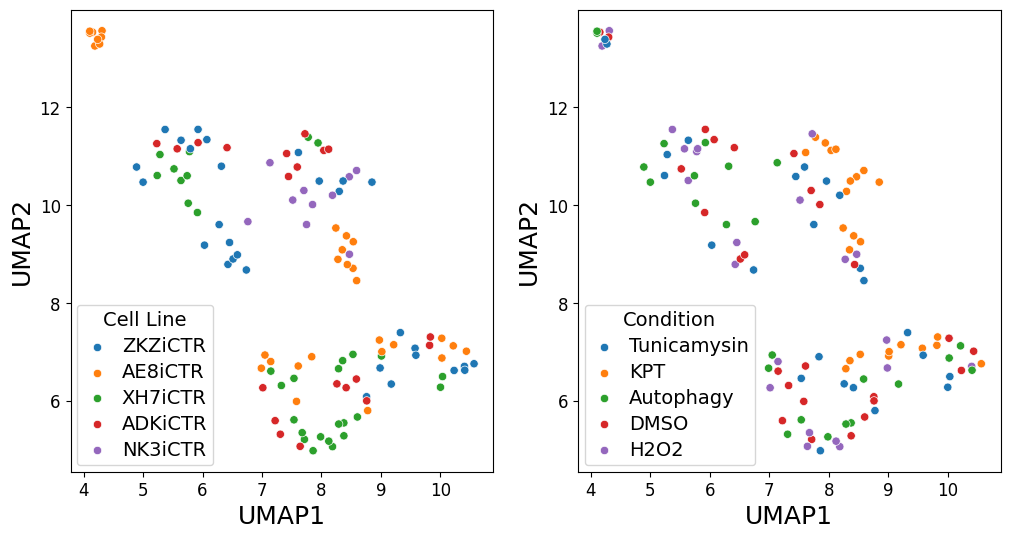

In [28]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Cell Line", ax=axs[0])
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Condition", ax=axs[1])
# increase legend font size

for ax in axs:
    for item in ax.get_legend().get_texts():
        item.set_fontsize(14)
# increase legend title font size
for ax in axs:
    for item in [ax.get_legend().get_title()]:
        item.set_fontsize(14)

# increase axis font size

for ax in axs:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)

    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
#sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Plate", ax=axs[2])
#plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/miccai/figures/umap.svg")

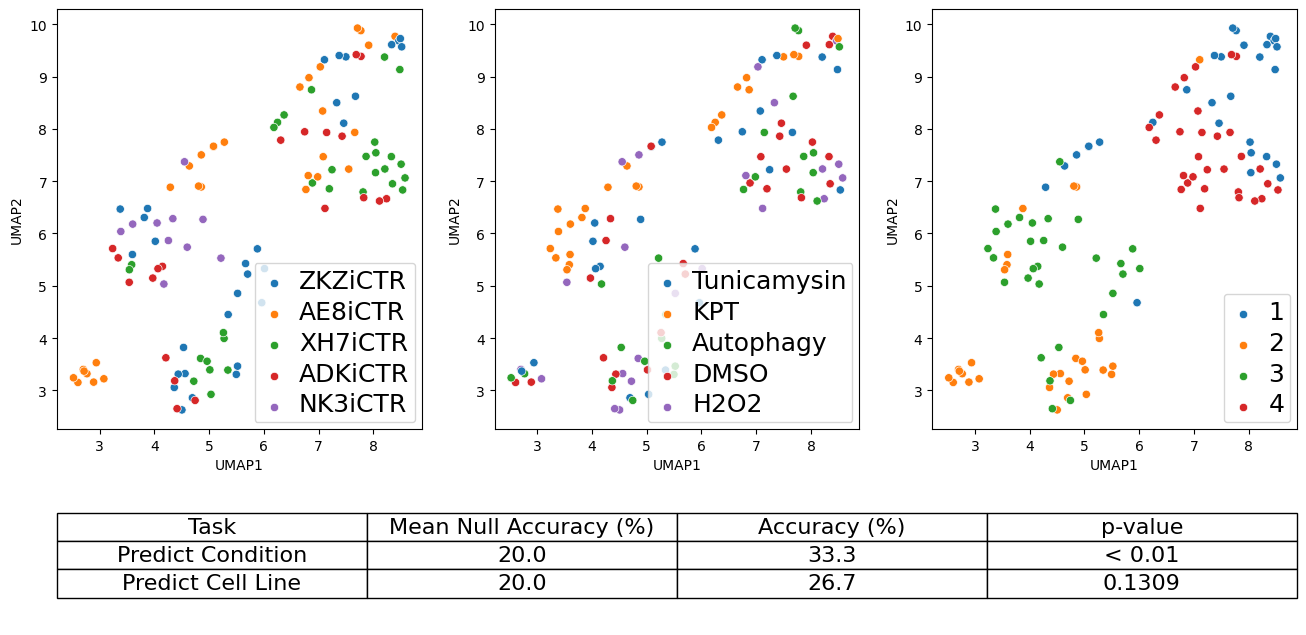

In [16]:
df_pred = pd.DataFrame({"Task": data_task, "Mean Null Accuracy (%)": data_null_acc, "Accuracy (%)": data_acc, "p-value": data_pval})
df_pred["Mean Null Accuracy (%)"] = df_pred["Mean Null Accuracy (%)"].round(1)
df_pred["Accuracy (%)"] = df_pred["Accuracy (%)"].round(1)
# df_pred = df_pred.drop(columns=["p-value"])
# df_pred["p-value"] = ["0.037", "< 0.001"]

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

# First row, two subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top-left subplot
ax2 = fig.add_subplot(gs[0, 1])  # Top-right subplot
ax3 = fig.add_subplot(gs[0, 2])  # Top-right subplot

# Second row, one subplot that spans both columns
ax4 = fig.add_subplot(gs[1, :])  # Bottom subplot spanning both columns


sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Cell Line", ax=ax1)
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Condition", ax=ax2)
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Plate", ax=ax3)

# move legend to bottom right in each axis
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')
# increase font size of the legends
for ax in [ax1, ax2, ax3]:
    for item in ax.get_legend().get_texts():
        item.set_fontsize(18)

ax4.axis('tight')
ax4.axis('off')
# make a new column called text that says ns if p-value is greater than 0.05, and stars if less than 0.05
df_pred["p-value"] = ["< 0.01" if pval < 0.01 else str(pval) for pval in df_pred["p-value"]]

table = ax4.table(cellText=df_pred.values, colLabels=df_pred.columns, cellLoc='center', loc='center')

# Set font size for each cell
table.auto_set_font_size(False)
table.set_fontsize(16)  # Adjust font size as needed
# increase cell size of table
table.scale(1, 1.7)
#plt.tight_layout()

#plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/batch_effect/batch.svg")

In [ ]:
X = df[cols_X].values
y = df["Metadata_Plate"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)*100

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)

marginals = np.sum(confusion_mat, axis=1)
k = len(marginals)
pvals = [1/float(k)] * k

accs = []
for iter in range(10000):
    rand_mat = []
    for marginal in marginals:
        row = np.random.multinomial(marginal, pvals = pvals)
        rand_mat.append(row)

    rand_mat = np.stack(rand_mat, axis=0)

    acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)
    accs.append(acc)

accs = np.array(accs)

print(f"p-value: {np.sum(accs >= accuracy/100)/len(accs)}")
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Plate")